In [1]:
!git clone https://github.com/Factral/image-stitching-supeglue

import os
os.chdir('image-stitching-supeglue')

Cloning into 'image-stitching-supeglue'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 30 (delta 1), reused 14 (delta 0), pack-reused 14
Receiving objects: 100% (30/30), 93.37 MiB | 13.36 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [16]:
# Running the super glue algorithm on outdoor dataset to match features
"""
    Do not resize the images,
    If you need to use the extracted keypoints,
    to process the "original" source images.

    Set the parameter to -1 to avoid resizing
    --resize -1

    Other parameter can be set as folows,
    to extract the best matching features.
    * Non maximum Suppression Radius = 5
    * Matching Confidence = 0.9
"""
!python match_pairs.py  --resize -1\
                        --superglue outdoor \
                        --max_keypoints 2048 \
                        --nms_radius 5 \
                        --resize_float \
                        --input_dir adobe_panorama/ \
                        --input_pairs adobe_panorama.txt \
                        --output_dir adobe_panorama/output \
                        --viz \
                        --keypoint_threshold 0.05 \
                        --match_threshold 0.9

Namespace(input_pairs='adobe_panorama.txt', input_dir='adobe_panorama/', output_dir='adobe_panorama/output', max_length=-1, resize=[-1], resize_float=True, superglue='outdoor', max_keypoints=2048, keypoint_threshold=0.05, nms_radius=5, sinkhorn_iterations=20, match_threshold=0.9, viz=True, eval=False, fast_viz=False, cache=False, show_keypoints=False, viz_extension='png', opencv_display=False, shuffle=False, force_cpu=False)
Will not resize images
Running inference on device "cpu"
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
Looking for data in directory "adobe_panorama"
Will write matches to directory "adobe_panorama/output"
Will write visualization images to directory "adobe_panorama/output"
[Finished pair     0 of     1] load_image=0.089 matcher=37.743 viz_match=1.590 total=39.422 sec {0.0 FPS} 


In [15]:
# generating the necessary txt file to input for the super glue algorithm
img_name = 'hotel' # set of outdoor images
num_images = 2
# Order of the images. To stitch left and right images as depicted in the below
order = range(num_images -1,0,-1)
with open('adobe_panorama.txt', 'w') as file:
    for i in order:
        file.write("{img}-{:02}.jpeg {img}-{:02}.jpeg\n".format(i,i-1, img = img_name))

In [22]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

npz_files = ["{img}-{:02}_{img}-{:02}_matches.npz".format(i,i-1, img = img_name) for i in order]
for file in npz_files:
    path = 'adobe_panorama/output/'+file
    npz = np.load(path)
print(npz.files)

['keypoints0', 'keypoints1', 'matches', 'match_confidence']


In [47]:
# extracting information from the npz files
def loadNPZ(npz_file):
    npz = np.load('adobe_panorama/output/'+ npz_file)
    point_set1 = npz['keypoints0'][npz['matches']>-1]
    matching_indexes =  npz['matches'][npz['matches']>-1] # -1 if the keypoint is unmatched
    point_set2 = npz['keypoints1'][matching_indexes]
    print("Number of matching points for the findHomography algorithm:")
    print("In left  image:", len(point_set1),"\nIn right image:", len(point_set2))
    return point_set1, point_set2

def pltSourceImages(imageSet):
    print('adobe_panorama/hotel-{:02}.jpeg'.format(imageSet))
    im_left = cv.imread('adobe_panorama/hotel-{:02}.jpeg'.format(imageSet),cv.IMREAD_ANYCOLOR)
    im_right = cv.imread('adobe_panorama/hotel-{:02}.jpeg'.format(imageSet -1),cv.IMREAD_ANYCOLOR)

    im_left = cv.cvtColor(im_left, cv.COLOR_BGR2RGB)
    im_right = cv.cvtColor(im_right, cv.COLOR_BGR2RGB)

    # Marking the detected features on the two images.
    for point in point_set1.astype(np.int32):
        cv.circle(im_left, tuple(point), radius=8, color=(255, 255, 0), thickness=-1)

    for point in point_set2.astype(np.int32):
        cv.circle(im_right, tuple(point), radius=8, color=(255, 255, 0), thickness=-1)

    print("Left image shape:", im_left.shape)
    print("Right image shape:", im_right.shape)

    fig = plt.figure(figsize = (10,10))
    plt.subplot(121),plt.imshow(im_left, cmap='gray', vmin = 0, vmax = 255)
    plt.subplot(122),plt.imshow(im_right, cmap='gray', vmin = 0, vmax = 255)
    plt.show()

def plotMatches(imageSet):
    plt.figure(figsize=(10,10))
    matched_points = cv.imread('adobe_panorama/output/hotel-{:02}_hotel-{:02}_matches.png'.\
                     format(imageSet, imageSet -1),cv.IMREAD_ANYCOLOR)
    plt.imshow(matched_points, cmap='gray', vmin = 0, vmax = 255)
    plt.show()

1
1
Number of matching points for the findHomography algorithm:
In left  image: 375 
In right image: 375
adobe_panorama/hotel-01.jpeg
Left image shape: (1600, 1200, 3)
Right image shape: (1600, 1200, 3)


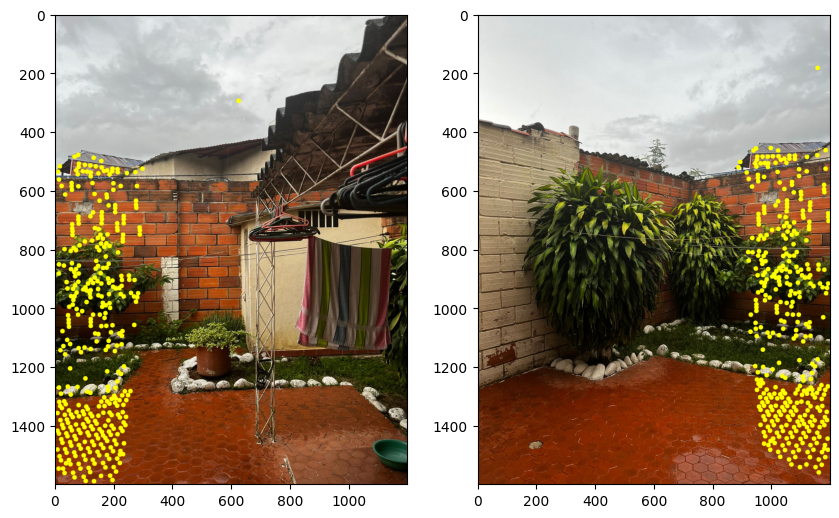

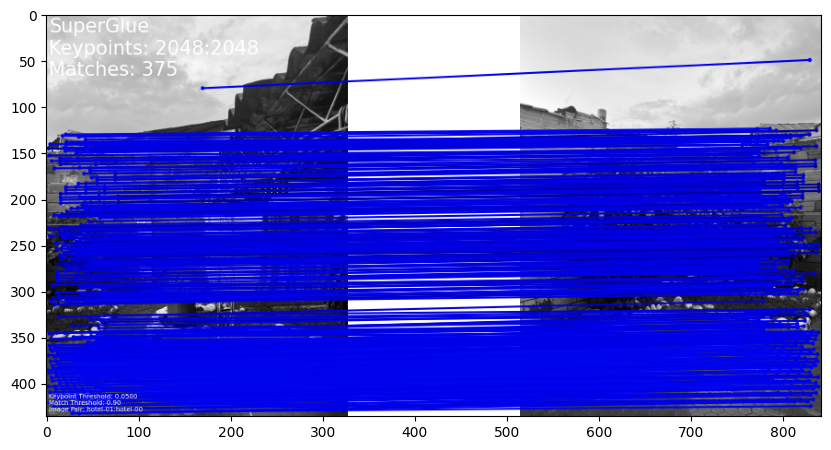

[[ 4.64239127e-01  6.33360344e-02  8.49441354e+02]
 [-3.55430873e-01  9.17238218e-01  2.38666797e+01]
 [-4.52892983e-04 -5.60711074e-06  1.00000000e+00]]


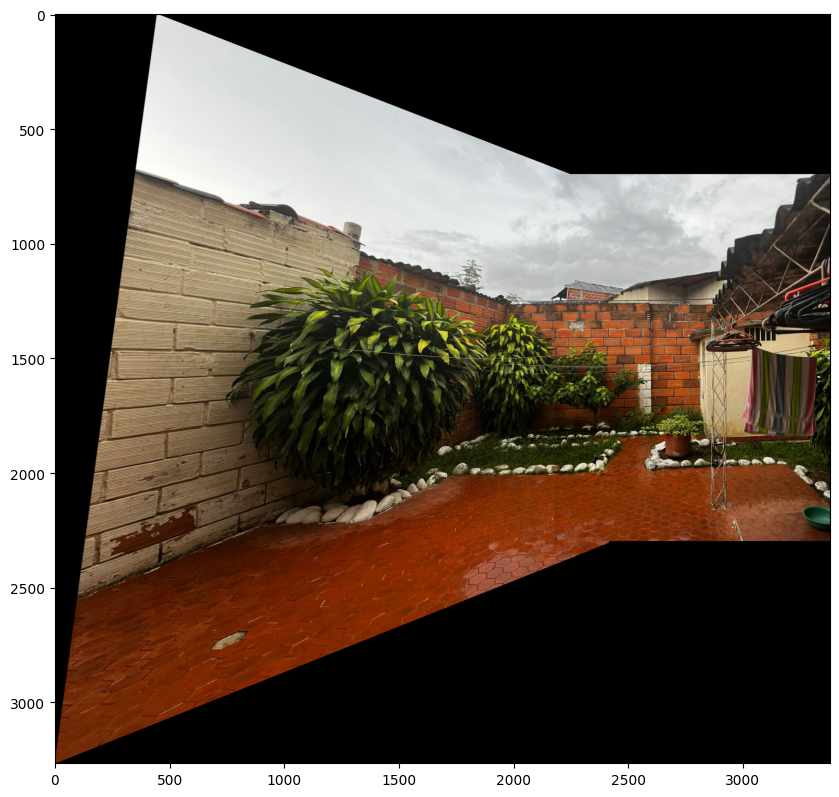

----------------------------------------------------------------------------------------------------


In [51]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Assuming all previous definitions (functions, etc.) are the same

for imgSet in range(num_images - 1, 5):
    # Load points
    print(imgSet)
    print(num_images - imgSet)
    point_set1, point_set2 = loadNPZ(npz_files[num_images - 1 - imgSet])

    # Plotting source images and matches
    pltSourceImages(imgSet)
    plotMatches(imgSet)

    # Load source images
    im_left = cv.imread('adobe_panorama/hotel-{:02}.jpeg'.format(imgSet), cv.IMREAD_ANYCOLOR)
    im_right = cv.imread('adobe_panorama/hotel-{:02}.jpeg'.format(imgSet - 1), cv.IMREAD_ANYCOLOR)

    # Finding Homography between two source images
    H, status = cv.findHomography(point_set1, point_set2, cv.RANSAC, 10.0)
    print(H)

    # Calculate the size of the output panorama canvas
    h_left, w_left = im_left.shape[:2]
    h_right, w_right = im_right.shape[:2]

    # Corners of the right image
    corners_right = np.array([
        [0, 0],
        [w_right - 1, 0],
        [w_right - 1, h_right - 1],
        [0, h_right - 1]
    ])

    # Transform corners to get the bounding box of the warped right image
    corners_right_transformed = cv.perspectiveTransform(np.float32([corners_right]), np.linalg.inv(H))[0]
    corners_all = np.vstack((corners_right_transformed, [[0, 0], [w_left, 0], [0, h_left], [w_left, h_left]]))

    # Find the extents of both the transformed and original images
    x_min, y_min = np.min(corners_all, axis=0).astype(int)
    x_max, y_max = np.max(corners_all, axis=0).astype(int)

    # Size of the panorama
    w_panorama = x_max - x_min
    h_panorama = y_max - y_min

    # Offset for translation
    offset = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])

    # Update the transformation matrix based on offset
    H_t = offset @ np.linalg.inv(H)

    # Warp the right image
    panorama = cv.warpPerspective(im_right, H_t, (w_panorama, h_panorama), cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

    # Place the left image in the panorama
    panorama[-y_min:h_left - y_min, -x_min:w_left - x_min] = im_left

    # Show the result
    plt.figure(figsize=(10, 10))
    plt.imshow(cv.cvtColor(panorama, cv.COLOR_BGR2RGB))
    plt.show()

    print("-" * 100)
    break
